In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
os.sys.path.append("..")
from src.models.vqvae import VQVAE
from src.models.vqvae_simple import VQVAE_simple
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torch
from torchvision.transforms import Compose

from torchxrayvision.datasets import XRayCenterCrop, XRayResizer, normalize, apply_transforms, relabel_dataset, SubsetDataset
from datawrappers import NIH_wrapper, CheX_wrapper, VINBig_wrapper

import wandb

transforms = Compose([XRayCenterCrop(),XRayResizer(224)])
nih_ds = NIH_wrapper(r"/mnt/mp1/@ais/nih_raw/%ob/",\
    csvpath=r"/mnt/mp1/@ais/nih_raw/%ob/Data_Entry_2017_v2020.csv",\
    bbox_list_path=r"/mnt/mp1/@ais/nih_raw/%ob/BBox_List_2017.csv",\
    unique_patients=True,
    transform=transforms)
vbg_ds = VINBig_wrapper(r"/mnt/mp1/@ais/vinbig/%ob/train",r"/mnt/mp1/@ais/vinbig/%ob/train.csv",transform=transforms)
chex_ds = CheX_wrapper(r"/mnt/mp1/@ais/chexpert_raw/%ob/CheXpert-v1.0-small",r"/mnt/mp1/@ais/chexpert_raw/%ob/CheXpert-v1.0-small/train.csv",transform=transforms)
total_ds = torch.utils.data.ConcatDataset([nih_ds,vbg_ds,chex_ds])
len(total_ds)


64411

In [21]:
train_ds, test_ds = torch.utils.data.random_split(total_ds,[45088,19323])
train_loader = DataLoader(train_ds, batch_size=200, shuffle=True,pin_memory=True,num_workers=20)
test_loader = DataLoader(test_ds, batch_size=200, shuffle=True,pin_memory=True,num_workers=20)

In [2]:
model = VQVAE_simple(
    in_channel=1,
    channel=128,
    n_res_block=1,
    n_res_channel=64,
    embed_dim=64,
    n_embed=512,
    params=None
)
checkpoint = torch.load("/home/luab/experiments/None/version_None/checkpoints/epoch=24-step=4524.ckpt", map_location = 'cpu')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [4]:
s = nih_ds[0]

In [5]:
c = model(torch.tensor(s['img']).unsqueeze(0))

In [8]:
c

(tensor([[[[  147.5853,   -74.7625,  -149.0535,  ...,  -889.2739,
             -798.9891,  -660.8664],
           [  121.5684,  -100.0981,  -238.4062,  ...,  -970.5655,
             -868.7725,  -758.3696],
           [  212.4654,   -22.9141,  -333.1928,  ..., -1010.9245,
             -975.4659,  -863.2348],
           ...,
           [  867.6387,   739.3678,   356.0438,  ...,  -931.4151,
             -939.6484,  -786.1217],
           [  698.8505,   486.9370,   421.9209,  ...,  -800.7251,
             -787.9294,  -831.0870],
           [  450.0112,   360.6652,   283.7033,  ...,  -730.4678,
             -780.8297,  -736.3116]]]], grad_fn=<ConvolutionBackward0>),
 tensor([2397.0173], grad_fn=<UnsqueezeBackward0>))

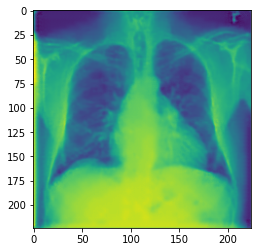

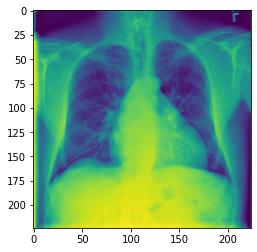

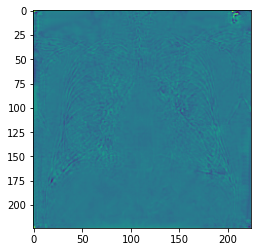

In [7]:
import matplotlib.pyplot as plt
plt.imshow(c[0].detach().numpy()[0][0])
plt.show()
plt.imshow(s['img'][0])
plt.show()
plt.imshow(s['img'][0]-c[0].detach().numpy()[0][0])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | enc_b           | Encoder         | 172 K 
1 | enc_t           | Encoder         | 426 K 
2 | quantize_conv_t | Conv2d          | 8.3 K 
3 | quantize_t      | Quantizer       | 0     
4 | dec_t           | Decoder         | 762 K 
5 | quantize_conv_b | Conv2d          | 8.3 K 
6 | quantize_b      | Quantizer       | 0     
7 | upsample_t      | ConvTranspose2d | 65.6 K
8 | dec             | Decoder         | 320 K 
9 | criterion       | MSELoss         | 0     
----------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.054     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]